## Acceleration of a FIR filter on the PYNQ-Z1
This tutorial demonstrates how to accelerate a Python function on the Zynq-7000 using PYNQ. We begin by testing a software FIR implementation, the SciPy function ```lfilter```, and measuring it's performance. Then we load a custom overlay with a hardware FIR, and compare it's performance to the software implementation.

#### Plot function for use in this notebook
The first code block below defines a function that we will use for plotting data throughout this notebook. Note that the function has a ```n_samples``` argument so that we can limit the number of samples to plot. Plotting more than a few thousand samples can be very slow and consume a lot of RAM.

In [2]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib notebook
def plot_to_notebook(time_sec, in_signal, n_samples, out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()

#### Generate the input signal
The next code block will generate a "noisy" signal that we will use as input to the FIR implementations. The main signal is a 200kHz sinusoid but we have added lower amplitude sinusoids at 46MHz and 12MHz to simulate noise.

In [4]:
import numpy as np

Number of samples:  200000


<IPython.core.display.Javascript object>


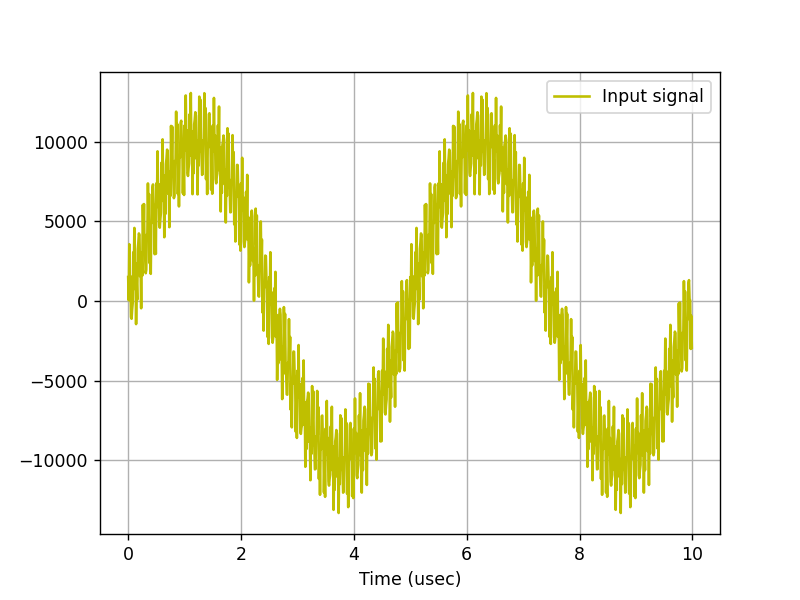

In [9]:
# Total time
T = 0.002
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
samples =  10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ', len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,1000)

#### Software FIR filter using SciPy
Now we use the ```lfilter``` function from SciPy to filter the signal using our filter coefficients. The coefficients implement a low pass filter with passband 0-5mHz, and they were generated using this website: http://t-filter.engineerjs.com/

![Alt text](filter-fir.png)

In [10]:
from scipy.signal import lfilter

Software FIR execution time:  0.09064459800720215 s


<IPython.core.display.Javascript object>


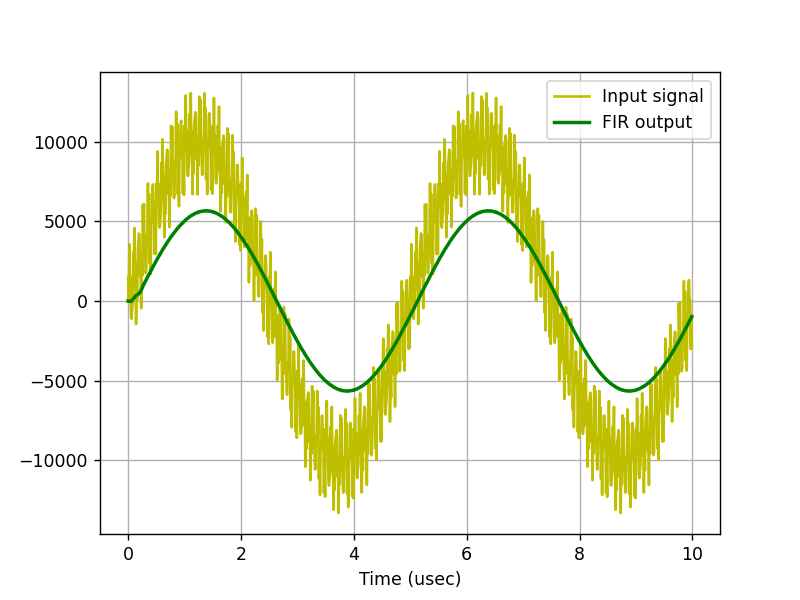

In [13]:
# coeff generated using http://t-filter.engineerjs.com/
coeffs = [-255, -260, -312, -288, -144, 153, 616, 1233, 1963, 2739, 3474, 4081, 4481, 4620, 4481, 4081, 3474, 2739, 1963, 1233, 616, 153, -144, -288, -312, -260, -255]

import time
start_time = time.time()
sw_fir_output = lfilter(coeffs, 70e3, samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ', sw_exec_time, 's')

# Plot the result to notebook
plot_to_notebook(t, samples, 1000, out_signal=sw_fir_output)

#### Hardware FIR implementation 
In the following code blocks, we test out the hardware FIR implemention and measure it's performance.

#### On host PC or PYNQ
- mv fir_accelerator.xsa fir_accelerator.zip
- unzip fir_accelerator.zip -d fir_accelerator_extracted
- find fir_accelerator_extracted -name "*.hwh"

In [28]:
from pynq import Overlay
import pynq.lib.dma

# Load the overlay
ol = Overlay('/home/xilinx/jupyter_notebooks/Projects/fir_accelerator.bit')

# Load the FIR DMA
dma = ol.filter.fir_dma

100.0
